In [1]:
import os
import os.path as osp
import time
import json
import imageio
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
import plotly.graph_objects as go
import matplotlib.animation as animation
import matplotlib.patches as patches

from radar_dataclass import *
from natsort import natsorted
from radar_data_preprocess import RadarData
from typing import List, Dict
from mpl_toolkits.mplot3d import Axes3D


plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

warnings.filterwarnings('ignore')

In [2]:
RADAR_DATA_DIR = '../../radar/chengdu-2025-02-26/json'

start_time = time.time()

data = RadarData(root_path=RADAR_DATA_DIR, duration_frames=0)

print(time.time() - start_time)

Loading raw RADAR frames by multi-processors...
Times usage: 17.678826093673706s.
17.685041904449463


In [3]:
frame_dict: Dict[int, Radar] = data.frame_dict
frame_info_list: List[frameHeader] = [frame_dict[keys].frameInfo for keys in frame_dict]

dets_list: List[detections] = [frame_dict[keys].dets for keys in frame_dict]
trks_list: List[tracks] = [frame_dict[keys].trks for keys in frame_dict]

In [4]:
len(dets_list[0].det_list)

519

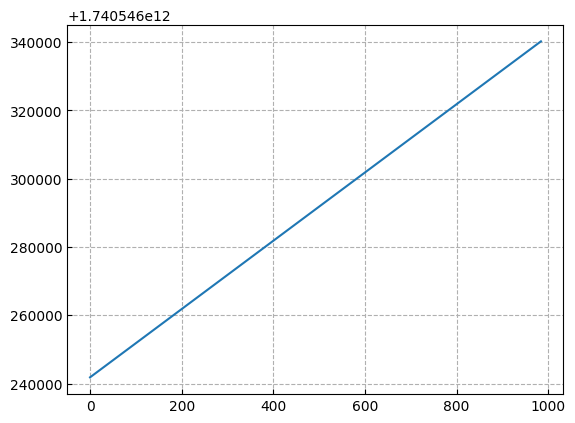

In [5]:
frame_time_list = list()

for frame_info in frame_info_list:
    frame_time_list.append(frame_info.add_frameTime_ms)

plt.plot(range(len(frame_time_list)), frame_time_list)
plt.grid(linestyle='--')

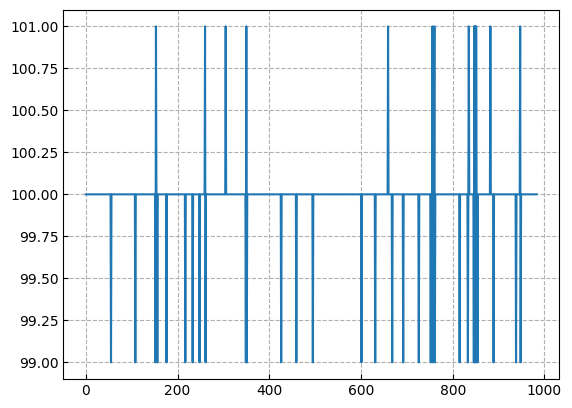

In [6]:
frame_diff_time_list = list()
frame_ref_time = frame_info_list[0].add_frameTime_ms

for frame_info in frame_info_list[1:]:
    frame_diff_time_list.append(frame_info.add_frameTime_ms - frame_ref_time)
    frame_ref_time = frame_info.add_frameTime_ms

plt.plot(range(len(frame_diff_time_list)), frame_diff_time_list)
plt.grid(linestyle='--')

Text(0.5, 0, 'Time interval (ms)')

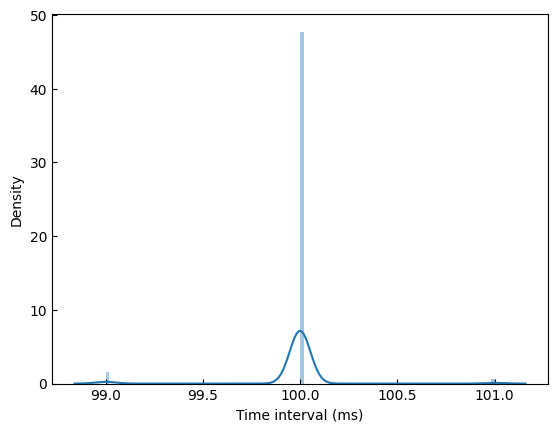

In [7]:
sns.distplot(frame_diff_time_list, bins=100)
plt.xlabel('Time interval (ms)')
# plt.savefig('Time interval density.svg', format='svg')

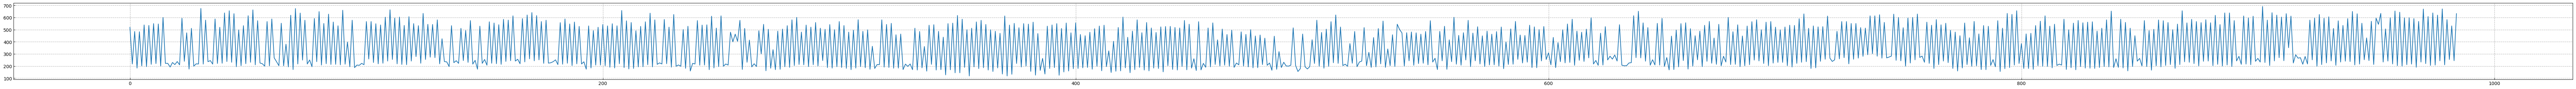

In [8]:
det_nums_list = list()

for det_frame in dets_list:
    det_nums_list.append(len(det_frame.det_list))

plt.figure(figsize=(100,3))
plt.plot(range(len(det_nums_list)), det_nums_list)
plt.grid(linestyle='--')
plt.savefig('Num of radar dets per frame')

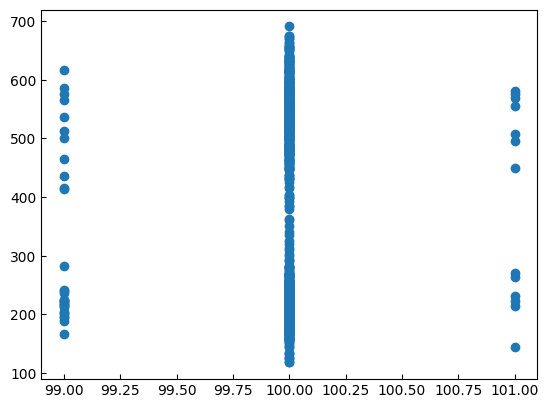

In [9]:
plt.scatter(frame_diff_time_list, det_nums_list[1:])

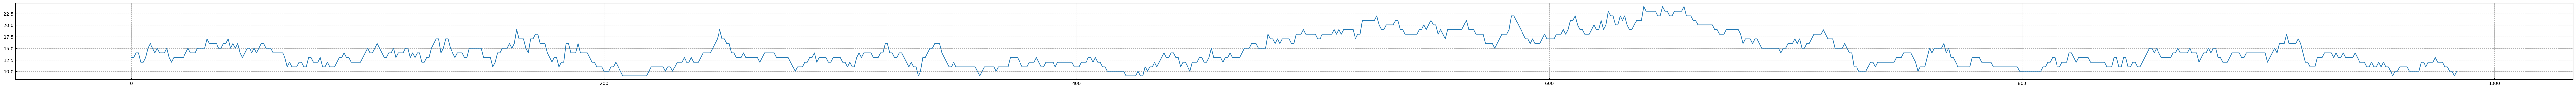

In [10]:
trk_nums_list = list()

for frame_info in frame_info_list:
    trk_nums_list.append(frame_info.numTracker)

plt.figure(figsize=(100,3))
plt.plot(range(len(trk_nums_list)), trk_nums_list)
plt.grid(linestyle='--')

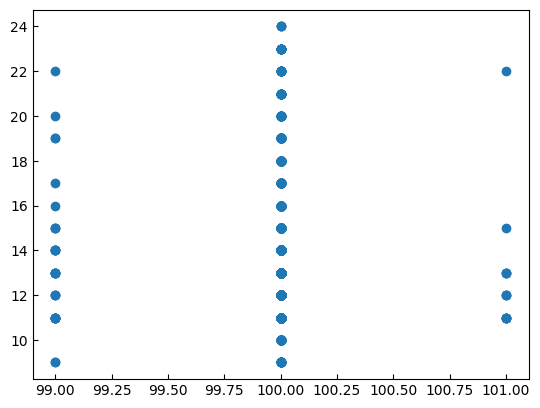

In [11]:
plt.scatter(frame_diff_time_list, trk_nums_list[1:])

In [12]:
fig = go.Figure(data=[go.Scatter3d(
    x=frame_diff_time_list,
    y=trk_nums_list[1:],
    z=det_nums_list[1:],
    mode='markers',  # 'lines', 'markers', 'lines+markers'
    marker=dict(
        size=1,
        color=det_nums_list[1:],    
        colorscale='Viridis',
        opacity=1
    )
)])

fig.update_layout(
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    ),
)

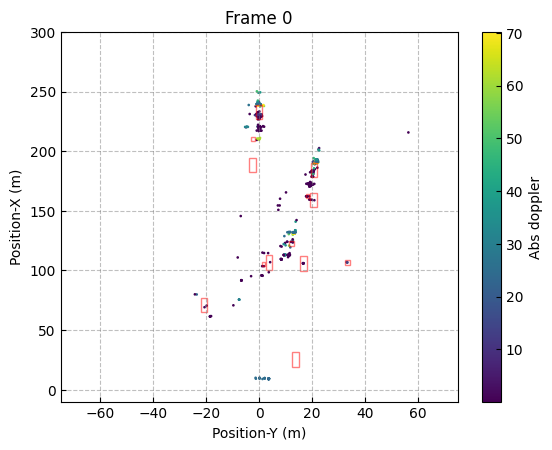

In [13]:
fig, ax = plt.subplots()

doppler_all_frames = []

for frame_idx in range(len(dets_list)):
    single_frame_dets_array = np.array([np.array([item.add_pos_x, item.add_pos_y, item.doppler]) for item in dets_list[frame_idx].det_list])
    doppler_all_frames.extend(np.abs(single_frame_dets_array[:, 2]))

doppler_min = min(doppler_all_frames)
doppler_max = max(doppler_all_frames)

cmap = 'viridis'
scatter = ax.scatter([], [], c=[], s=10, cmap=cmap, vmin=doppler_min, vmax=doppler_max)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Abs doppler')

def update(frame_idx):
    ax.clear()
    
    single_frame_dets_array = np.array([np.array([item.add_pos_x, item.add_pos_y, item.doppler]) for item in dets_list[frame_idx].det_list])
    doppler_vals = single_frame_dets_array[:, 2] 

    for coll in ax.collections:
        coll.remove()
    
    scatter = ax.scatter(single_frame_dets_array[:, 1], single_frame_dets_array[:, 0], c=doppler_vals, s=0.8, cmap=cmap, vmin=doppler_min, vmax=doppler_max)
    
    single_frame_trks_array = np.array([np.array([item.x, item.y, item.xSize, item.ySize]) for item in trks_list[frame_idx].trk_list])

    for i in range(len(single_frame_trks_array)):
        x_center = single_frame_trks_array[i, 0] / 64
        y_center = single_frame_trks_array[i, 1] / 64

        square_width  = single_frame_trks_array[i, 2] / 64
        square_height = single_frame_trks_array[i, 3] / 64

        rect = patches.Rectangle((x_center - square_width / 2, y_center - square_height / 2),
                                 square_width, square_height,
                                 linewidth=1, edgecolor='r', facecolor='none', alpha=0.5)
        
        ax.add_patch(rect)
    
    ax.set_title(f'Frame {frame_idx}')
    ax.set_xlim(-75, 75)
    ax.set_ylim(-10, 300)
    ax.set_xlabel('Position-Y (m)')
    ax.set_ylabel('Position-X (m)')
    ax.grid(True, linestyle='--', color='gray', alpha=0.5)

ani = animation.FuncAnimation(fig, update, frames=len(dets_list), repeat=False, interval=100)
save_floder = '../../result/plot'
# ani.save(osp.join(save_floder, '{}:radar_det_trk_visualize.gif'.format(RADAR_DATA_DIR.split('/')[3])), writer='imagemagick')

In [14]:
aa = np.array([frame_dict[keys].rd.rangeDoppler for keys in frame_dict])

In [15]:
rd_tensor = (np.array([frame_dict[keys].rd.rangeDoppler for keys in frame_dict]) - 2506) / ((6180 - 2506) / 255)
rd_tensor.shape

(985, 512, 512)

In [16]:
rd_tensor.max()

4392.399292324442

In [17]:
rd_tensor

array([[[4390.52531301, 4389.13718019, 4384.97278171, ...,
         4377.82389766, 4383.79286881, 4389.13718019],
        [4389.62302667, 4388.44311377, 4383.37642896, ...,
         4378.03211758, 4381.433043  , 4388.16548721],
        [4388.37370713, 4387.818454  , 4384.13990201, ...,
         4376.78279804, 4378.79559064, 4386.08328797],
        ...,
        [4377.26864453, 4376.78279804, 4376.7133914 , ...,
         4376.57457812, 4377.06042461, 4377.61567774],
        [4380.66956995, 4379.42025041, 4377.61567774, ...,
         4376.92161132, 4376.99101796, 4380.66956995],
        [4388.9983669 , 4387.61023408, 4382.05770278, ...,
         4377.12983125, 4379.0732172 , 4387.61023408]],

       [[4390.31709309, 4388.9983669 , 4384.6257485 , ...,
         4377.40745781, 4383.72346217, 4388.92896026],
        [4389.48421339, 4388.30430049, 4384.2787153 , ...,
         4377.19923789, 4381.01660316, 4387.88786064],
        [4388.37370713, 4387.818454  , 4384.13990201, ...,
         4377.

In [18]:
import cv2

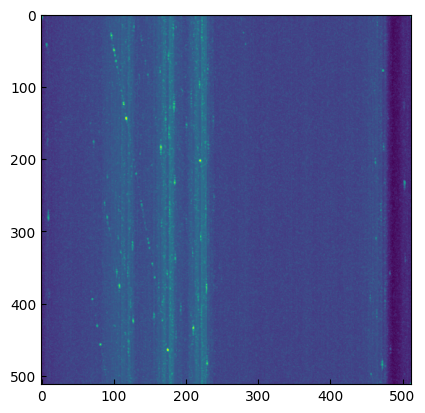

In [19]:
img_array = plt.imshow(aa[0]).get_array()

# 3. 归一化到 0-255 并转换为 uint8
img_uint8 = (img_array * 255).astype(np.uint8)

In [22]:
aa[0]

array([[228, 208, 148, ...,  45, 131, 208],
       [215, 198, 125, ...,  48,  97, 194],
       [197, 189, 136, ...,  30,  59, 164],
       ...,
       [ 37,  30,  29, ...,  27,  34,  42],
       [ 86,  68,  42, ...,  32,  33,  86],
       [206, 186, 106, ...,  35,  63, 186]], dtype=uint8)

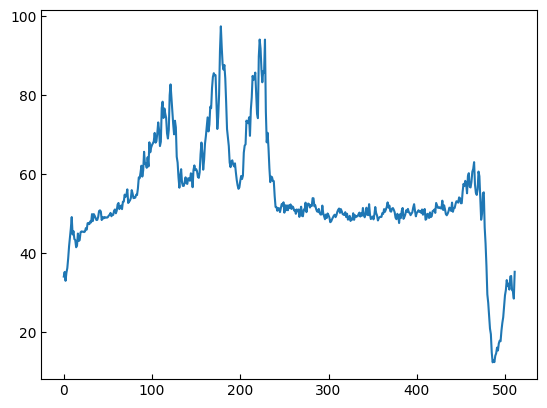

In [27]:
bb = np.mean(aa[0], axis=0)
plt.plot(np.arange(bb.shape[0]), bb)

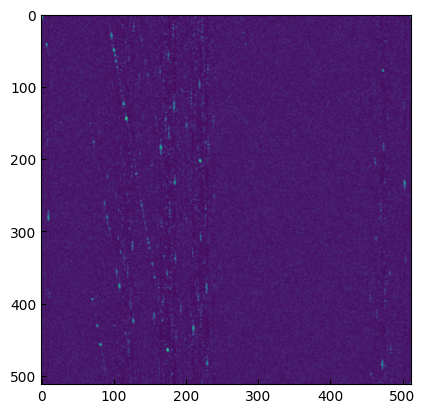

In [37]:
plt.imshow(aa[0] - np.repeat(bb, repeats=512, axis=0).reshape(512, 512).T)

In [29]:
bb

array([33.96289062, 35.13671875, 32.89257812, 34.95703125, 36.11914062,
       38.625     , 41.68359375, 43.81835938, 46.21679688, 49.0703125 ,
       44.66015625, 45.50585938, 43.48828125, 43.265625  , 41.40820312,
       41.82226562, 44.890625  , 43.01367188, 43.20507812, 45.19140625,
       45.42773438, 45.34960938, 45.40039062, 45.2578125 , 45.41015625,
       46.26171875, 45.89257812, 47.5       , 47.58789062, 47.28125   ,
       47.98242188, 47.71875   , 49.8203125 , 48.08789062, 49.82617188,
       49.41015625, 48.8671875 , 48.31640625, 48.36914062, 49.140625  ,
       50.60742188, 50.78320312, 50.4765625 , 48.31640625, 49.04101562,
       48.7109375 , 49.0859375 , 48.89648438, 48.98242188, 48.91601562,
       49.07226562, 49.46875   , 49.6328125 , 50.12890625, 49.28125   ,
       49.64648438, 49.62109375, 50.68359375, 51.00390625, 50.02929688,
       50.67382812, 52.265625  , 52.65234375, 51.09375   , 51.63671875,
       51.99804688, 51.08203125, 52.95703125, 52.99804688, 54.77

In [20]:
decoded_image = cv2.imdecode(encoded_image, cv2.IMREAD_COLOR)
cv2.imshow("Decoded Image", decoded_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

NameError: name 'encoded_image' is not defined

In [ ]:
_, encoded_image = cv2.imencode('.png', img_uint8)

In [ ]:
a = cv2.imshow(img_uint8)

error: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'imshow'
> Overload resolution failed:
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)


In [ ]:
cv2.imencode('.jpg', a, [cv2.IMWRITE_JPEG_QUALITY, 20])[1].tobytes()